In [3]:
%matplotlib_svg
import pylab as pl
import numpy as np

## 拟合与优化-optimize

### 非线性方程组求解

In [2]:
from math import sin, cos
from scipy import optimize

def f(x): #❶
    x0, x1, x2 = x.tolist() #❷
    return [
        5*x1+3,
        4*x0*x0 - 2*sin(x1*x2),
        x1*x2 - 1.5
    ]

# f计算方程组的误差，[1,1,1]是未知数的初始值
result = optimize.fsolve(f, [1,1,1]) #❸
print result
print f(result)

[-0.70622057 -0.6        -2.5       ]
[0.0, -9.126033262418787e-14, 5.329070518200751e-15]


In [3]:
def j(x): #❶
    x0, x1, x2 = x.tolist()
    return [
        [0, 5, 0],
        [8*x0, -2*x2*cos(x1*x2), -2*x1*cos(x1*x2)],
        [0, x2, x1]
    ]
 
result = optimize.fsolve(f, [1,1,1], fprime=j) #❷
print result
print f(result)

[-0.70622057 -0.6        -2.5       ]
[0.0, -9.126033262418787e-14, 5.329070518200751e-15]


### 最小二乘拟合

In [5]:
import numpy as np
from scipy import optimize

X = np.array([ 8.19,  2.72,  6.39,  8.71,  4.7 ,  2.66,  3.78])
Y = np.array([ 7.01,  2.78,  6.47,  6.71,  4.1 ,  4.23,  4.05])

def residuals(p): #❶
    "计算以p为参数的直线和原始数据之间的误差"
    k, b = p
    return Y - (k*X + b)

# leastsq使得residuals()的输出数组的平方和最小，参数的初始值为[1,0]
r = optimize.leastsq(residuals, [1, 0]) #❷
k, b = r[0]
print "k =",k, "b =",b

k = 0.613495349193 b = 1.79409254326


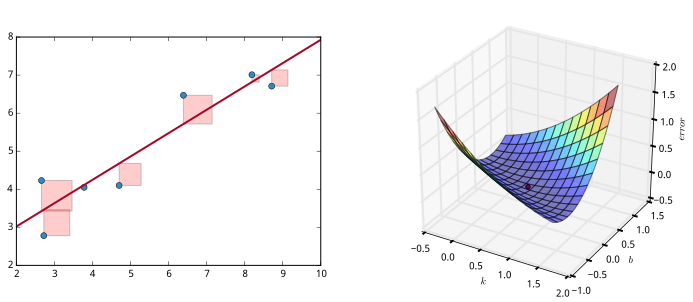

In [6]:
#%figonly=最小化正方形面积之和（左），误差曲面（右）
scale_k = 1.0
scale_b = 10.0
scale_error = 1000.0

def S(k, b):
    "计算直线y=k*x+b和原始数据X、Y的误差的平方和"
    error = np.zeros(k.shape)
    for x, y in zip(X, Y):
        error += (y - (k * x + b)) ** 2
    return error

ks, bs = np.mgrid[k - scale_k:k + scale_k:40j, b - scale_b:b + scale_b:40j]
error = S(ks, bs) / scale_error

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle

fig = pl.figure(figsize=(12, 5))

ax1 = pl.subplot(121)

ax1.plot(X, Y, "o")
X0 = np.linspace(2, 10, 3)
Y0 = k*X0 + b
ax1.plot(X0, Y0)

for x, y in zip(X, Y):
    y2 = k*x+b
    rect = Rectangle((x,y), abs(y-y2), y2-y, facecolor="red", alpha=0.2)
    ax1.add_patch(rect)

ax1.set_aspect("equal")


ax2 = fig.add_subplot(122, projection='3d')

ax2.plot_surface(
    ks, bs / scale_b, error, rstride=3, cstride=3, cmap="jet", alpha=0.5)
ax2.scatter([k], [b / scale_b], [S(k, b) / scale_error], c="r", s=20)
ax2.set_xlabel("$k$")
ax2.set_ylabel("$b$")
ax2.set_zlabel("$error$");

真实参数: [10, 0.34, 0.5235987755982988]
拟合参数 [ 10.25218748   0.3423992    0.50817424]


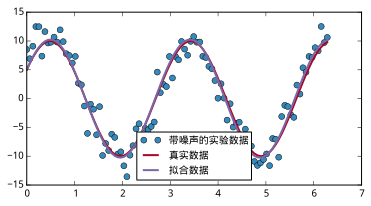

In [17]:
#%fig=带噪声的正弦波拟合
def func(x, p): #❶
    """
    数据拟合所用的函数: A*sin(2*pi*k*x + theta)
    """
    A, k, theta = p
    return A*np.sin(2*np.pi*k*x+theta)   

def residuals(p, y, x): #❷
    """
    实验数据x, y和拟合函数之间的差，p为拟合需要找到的系数
    """
    return y - func(x, p)

x = np.linspace(0, 2*np.pi, 100)
A, k, theta = 10, 0.34, np.pi/6 # 真实数据的函数参数
y0 = func(x, [A, k, theta]) # 真实数据
# 加入噪声之后的实验数据
np.random.seed(0)
y1 = y0 + 2 * np.random.randn(len(x)) #❸

p0 = [7, 0.40, 0] # 第一次猜测的函数拟合参数

# 调用leastsq进行数据拟合
# residuals为计算误差的函数
# p0为拟合参数的初始值
# args为需要拟合的实验数据
plsq = optimize.leastsq(residuals, p0, args=(y1, x)) #❹

print u"真实参数:", [A, k, theta] 
print u"拟合参数", plsq[0] # 实验数据拟合后的参数

pl.plot(x, y1, "o", label=u"带噪声的实验数据")
pl.plot(x, y0, label=u"真实数据")
pl.plot(x, func(x, plsq[0]), label=u"拟合数据")
pl.legend(loc="best");

In [18]:
def func2(x, A, k, theta):
    return A*np.sin(2*np.pi*k*x+theta)   

popt, _ = optimize.curve_fit(func2, x, y1, p0=p0)
print popt

[ 10.25218748   0.3423992    0.50817424]


In [19]:
popt, _ = optimize.curve_fit(func2, x, y1, p0=[10, 1, 0])
print u"真实参数:", [A, k, theta]
print u"拟合参数", popt

真实参数: [10, 0.34, 0.5235987755982988]
拟合参数 [ 0.71093473  1.02074599 -0.1277666 ]


### 计算函数局域最小值

In [54]:
def target_function(x, y):
    return (1-x)**2 + 100*(y-x**2)**2    

class TargetFunction(object):
    
    def __init__(self):
        self.f_points = []
        self.fprime_points = []
        self.fhess_points = []
        
    def f(self, p):
        x, y = p.tolist()
        z = target_function(x, y)
        self.f_points.append((x, y))
        return z
        
    def fprime(self, p):
        x, y = p.tolist()
        self.fprime_points.append((x, y))
        dx = -2 + 2*x - 400*x*(y - x**2)
        dy = 200*y - 200*x**2
        return np.array([dx, dy])
    
    def fhess(self, p):
        x, y = p.tolist()
        self.fhess_points.append((x, y))
        return np.array([[2*(600*x**2 - 200*y + 1), -400*x],
                         [-400*x, 200]])
 
def fmin_demo(method):
    target = TargetFunction()
    init_point =(-1, -1)
    res = optimize.minimize(target.f, init_point, 
                      method=method,
                      jac=target.fprime,
                      hess=target.fhess)
    return res, [np.array(points) for points in 
                (target.f_points, target.fprime_points, target.fhess_points)]

methods = ("Nelder-Mead", "Powell", "CG", "BFGS", "Newton-CG", "L-BFGS-B")
for method in methods:
    res, (f_points, fprime_points, fhess_points) = fmin_demo(method)
    print "{:12s}: min={:12g}, f count={:3d}, fprime count={:3d}, fhess count={:3d}".format(
        method, float(res["fun"]), len(f_points), len(fprime_points), len(fhess_points))

Nelder-Mead : min= 5.30934e-10, f count=125, fprime count=  0, fhess count=  0
Powell      : min=           0, f count= 52, fprime count=  0, fhess count=  0
CG          : min=  7.6345e-15, f count= 34, fprime count= 34, fhess count=  0
BFGS        : min= 2.31605e-16, f count= 40, fprime count= 40, fhess count=  0
Newton-CG   : min= 5.22666e-10, f count= 60, fprime count= 97, fhess count= 38
L-BFGS-B    : min=  6.5215e-15, f count= 33, fprime count= 33, fhess count=  0


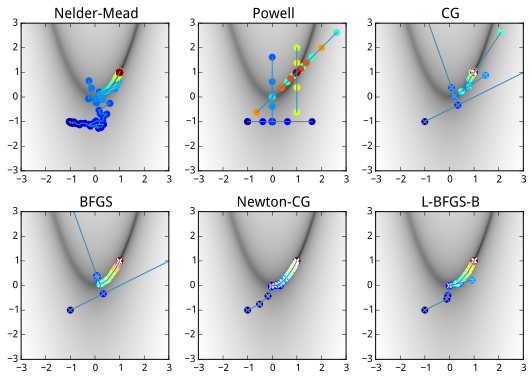

In [56]:
#%figonly=各种优化算法的搜索路径
def draw_fmin_demo(f_points, fprime_points, ax):
    xmin, xmax = -3, 3
    ymin, ymax = -3, 3
    Y, X = np.ogrid[ymin:ymax:500j,xmin:xmax:500j]
    Z = np.log10(target_function(X, Y))
    zmin, zmax = np.min(Z), np.max(Z)
    ax.imshow(Z, extent=(xmin,xmax,ymin,ymax), origin="bottom", aspect="auto", cmap="gray")
    ax.plot(f_points[:,0], f_points[:,1], lw=1)
    ax.scatter(f_points[:,0], f_points[:,1], c=range(len(f_points)), s=50, linewidths=0)
    if len(fprime_points):
        ax.scatter(fprime_points[:, 0], fprime_points[:, 1], marker="x", color="w", alpha=0.5)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

fig, axes = pl.subplots(2, 3, figsize=(9, 6))
methods = ("Nelder-Mead", "Powell", "CG", "BFGS", "Newton-CG", "L-BFGS-B")
for ax, method in zip(axes.ravel(), methods):
    res, (f_points, fprime_points, fhess_points) = fmin_demo(method)
    draw_fmin_demo(f_points, fprime_points, ax)
    ax.set_aspect("equal")
    ax.set_title(method)

### 计算全域最小值

In [57]:
def func(x, p):
    A, k, theta = p
    return A*np.sin(2*np.pi*k*x+theta)

def func_error(p, y, x):
    return np.sum((y - func(x, p))**2)   

x = np.linspace(0, 2*np.pi, 100)
A, k, theta = 10, 0.34, np.pi/6 
y0 = func(x, [A, k, theta])
np.random.seed(0)
y1 = y0 + 2 * np.random.randn(len(x))

In [58]:
result = optimize.basinhopping(func_error, (1, 1, 1),
                      niter = 10,
                      minimizer_kwargs={"method":"L-BFGS-B",
                                        "args":(y1, x)})
print result.x

[ 10.25218694  -0.34239909   2.63341582]


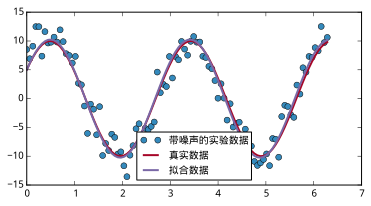

In [59]:
#%figonly=用`basinhopping()`拟合正弦波
pl.plot(x, y1, "o", label=u"带噪声的实验数据")
pl.plot(x, y0, label=u"真实数据")
pl.plot(x, func(x, result.x), label=u"拟合数据")
pl.legend(loc="best");